# Import Libraries and Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, average_precision_score, roc_auc_score, classification_report

# Reset Plot Settings
plt.rcdefaults()

In [ ]:
df = pd.read_csv('bar_pass_prediction.csv')

## Printing First 5 Rows of the Data

In [ ]:
df.head()

,decile1b,decile3,ID,decile1,sex,race,cluster,lsat,ugpa,zfygpa,...,hisp,pass_bar,bar,bar_passed,tier,index6040,indxgrp,indxgrp2,dnn_bar_pass_prediction,gpa
0,10.0,10.0,2,10.0,1.0,7.0,1.0,44.0,3.5,1.33,...,0,1,a Passed 1st time,True,4.0,886.842082,g 700+,i 820+,0.979804,3.5
1,5.0,4.0,3,5.0,1.0,7.0,2.0,29.0,3.5,-0.11,...,0,1,a Passed 1st time,True,2.0,649.999987,f 640-700,f 640-700,0.979804,3.5
2,3.0,2.0,36,3.0,2.0,7.0,3.0,36.0,3.5,-0.64,...,0,1,a Passed 1st time,True,3.0,760.526298,g 700+,h 760-820,0.979804,3.5
3,7.0,4.0,52,7.0,2.0,7.0,3.0,39.0,3.5,0.34,...,0,1,a Passed 1st time,True,3.0,807.894717,g 700+,h 760-820,0.979804,3.5
4,9.0,8.0,55,9.0,2.0,7.0,4.0,48.0,3.5,1.02,...,0,1,a Passed 1st time,True,5.0,949.999974,g 700+,i 820+,0.979804,3.5


# Data Pre-Processing (Cleaning)

In [ ]:
column_names = list(df.columns)
print(column_names)

['decile1b', 'decile3', 'ID', 'decile1', 'sex', 'race', 'cluster', 'lsat', 'ugpa', 'zfygpa', 'DOB_yr', 'grad', 'zgpa', 'bar1', 'bar1_yr', 'bar2', 'bar2_yr', 'fulltime', 'fam_inc', 'age', 'gender', 'parttime', 'male', 'race1', 'race2', 'Dropout', 'other', 'asian', 'black', 'hisp', 'pass_bar', 'bar', 'bar_passed', 'tier', 'index6040', 'indxgrp', 'indxgrp2', 'dnn_bar_pass_prediction', 'gpa']


**These are the columns we chose to remove:**

1. decile1b: Decile 1 and 3 seem to be more intuitive, and there are no values missing in decile1 that are present in decile1b
2. ID: Index column with no predictive power and no duplicates
3. sex, male: These are all different ways to list the same variable, gender. Converting the gender column to be binary should be the only thing we need to do.
4. race, race2, other, asian, black, hisp: These variables are less complete representations of student race than race1.
5. cluster: Unclear what this represents and no correlation with passing the bar.
6. zfygpa, zgpa, gpa: These are forms of law-school GPA, and GPA is identical to UGPA. Deciles are more intuitive than these numbers and there is correlation between decile1/1b to zfygpa and decile3 to zgpa.
7. DOB_yr, age: DOB_yr seems to represent the year a student was born and age seems to represent age. However, all the age variables are negative and even if you took their absolute values, they seem to be the ages of people taking the bar. Also, the data comes from a survey taken of people who started law school in 1991 and 9 of the DOB_yr entries are from before 1920. That means 9 of the people surveyed were 71 years old when they started law school. 70 of them were over 50 and one was 81. That seems fishy to me. Furthermore, neither of these variables correlate with bar_passed.
8. bar1, bar1_yr, bar2, bar2_yr, bar, pass_bar: These all give info on when a student passed the bar or just repeat bar_passed. These could be useful if we want to predict when someone may pass the bar.
9. parttime: Opposite of fulltime
10. Dropout: This appears to represent whether someone dropped out of law school and still passed the bar. However, there is only one YES value, so the predictive value is likely very low.
11. index6040: No correlation with passing the bar.
12. dnn_bar_pass_prediction: This is another algorithm’s prediction of whether a student will pass the bar. We probably don't need this.

**These are the variables we chose to keep:**

1. decile1, decile3: Deciles are a way for law schools to report class rankings. For example, decile1 most likely refers to year 1 GPA.
2. lsat: LSAT score received by the student.
3. ugpa: A student's undergraduate GPA.
4. grad: Did the student graduate from law school. This variable has Y, X, and O, which likely correspond to to Yes or Transfer/No.
5. fulltime: Did the student attend law school full time.
6. fam_inc: Family income; appears to be broken into quintiles.
8. gender: Gender of the student.
9. bar_passed: Boolean target column for convenience, of whether someone passed the bar at any point
10. tier: Tier of law school the student attended.
11. indxgrp, indxgrp2: Unclear what these mean, but both have a strong correlation to passing the bar, so getting rid of them is not as viable.
12. race1: Race of the student. This column had the most complete representation of all the race columns.

In [ ]:
# Filling null values for gender with 'male' - most frequent value in the column
df['gender'] = df['gender'].fillna('male')

In [ ]:
# Binarizing gender column
df['gender'].replace('male', 1, inplace = True)
df['gender'].replace('female', 0, inplace = True)

In [ ]:
# Filling null values for race1 with 'white' - most frequent value in the column
df['race1'] = df['race1'].fillna('white')

In [ ]:
# Binarizing grad column - lumping single outlier O with 0
df['grad'].replace(['Y', 'X','O'],[1,0,0], inplace = True)

In [ ]:
# Listing Columns to Remove and Removing Them

columns_to_remove = ['ID','gpa','zgpa','zfygpa','cluster','bar1','bar1_yr',
                     'bar2','bar2_yr','pass_bar','bar','race','race2','asian',
                    'black','hisp','other','Dropout','parttime','DOB_yr','age',
                    'index6040','dnn_bar_pass_prediction','sex','male','decile1b']

df.drop(columns = columns_to_remove, inplace=True)

In [ ]:
# Turning indxgrp into integers that we can interpret as "bins"
df['indxgrp'].replace({'g 700+': 7, 'f 640-700': 6, 'e 580-640': 5, 'd 520-580': 4, 'c 460-520': 3, 'b 400-460': 2, 'a under 400': 1}, inplace=True)
df['indxgrp2'].replace({'i 820+': 9, 'f 640-700': 6, 'h 760-820': 8, 'g 700-760': 7, 'e 580-640': 5, 'd 520-580': 4, 'c 460-520': 3,
                        'b 400-460': 2, 'a under 400': 1}, inplace=True)

In [ ]:
# Binarizing remaining categorical variables
df_binarized = pd.get_dummies(df)

In [ ]:
# Filling null values for grad with 1 - most frequent value in the column
df_binarized['grad'] = df_binarized['grad'].fillna(1)

In [ ]:
# Filling null values for fulltime with 1 - most frequent value in the column
df_binarized['fulltime'] = df_binarized['fulltime'].fillna(1)

In [ ]:
# Filling null values for fam_inc with 4 - most frequent value in the column
df_binarized['fam_inc'] = df_binarized['fam_inc'].fillna(4)

In [ ]:
# Filling null values for tier with 3 - most frequent value in the column
df_binarized['tier'] = df_binarized['tier'].fillna(3)

In [ ]:
# Filling null values for decile3 and decile1 with the mean column value
#df_binarized['decile3'] = df_binarized['decile3'].fillna(df_binarized['decile1'].mean())
#df_binarized['decile1'] = df_binarized['decile1'].fillna(df_binarized['decile1'].mean())

A better way to impute the decile values is by predicting them the way we would a target variable and using those predictions to fill the NANs. I used GridSearchCV to perform hyperparameter optimization. The optimal model to impute the values for both deciles was a GradientBoostingRegressor, so for efficiency, I only included the code for it below. The only parameter that changes between the two was max_features. This technique could also be expanded to all other features.

In [ ]:
# Decile 3 Imputation

train_data = df_binarized[df_binarized['decile3'].notnull()]
test_data = df_binarized[df_binarized['decile3'].isnull()]
features = train_data.columns.drop(['decile1', 'decile3'])

X_train = train_data[features]
y_train = train_data['decile3']

model = GradientBoostingRegressor(learning_rate = 0.1, max_depth = 4, max_features = 'sqrt', n_estimators = 100, random_state = 3)
model.fit(X_train, y_train)

X_test = test_data[features]
predicted_decile3 = model.predict(X_test)
df_binarized.loc[df_binarized['decile3'].isnull(), 'decile3'] = predicted_decile3
df_binarized['decile3'] = df_binarized['decile3'].astype(float)

In [ ]:
# Decile 1 Imputation

train_data = df_binarized[df_binarized['decile1'].notnull()]
test_data = df_binarized[df_binarized['decile1'].isnull()]
features = train_data.columns.drop(['decile1', 'decile3'])

X_train = train_data[features]
y_train = train_data['decile1']

model = GradientBoostingRegressor(learning_rate = 0.1, max_depth = 4, max_features = 0.7, n_estimators = 100, random_state = 3)
model.fit(X_train, y_train)

X_test = test_data[features]
predicted_decile3 = model.predict(X_test)
df_binarized.loc[df_binarized['decile1'].isnull(), 'decile1'] = predicted_decile3
df_binarized['decile1'] = df_binarized['decile1'].astype(float)

In [ ]:
# Checking the distribution of null values.
df_binarized.isnull().sum()

decile3        0
decile1        0
lsat           0
ugpa           0
grad           0
fulltime       0
fam_inc        0
gender         0
bar_passed     0
tier           0
indxgrp        0
indxgrp2       0
race1_asian    0
race1_black    0
race1_hisp     0
race1_other    0
race1_white    0
dtype: int64

In [ ]:
# Changing all numerical columns except for UGPA to be integers
df_binarized[['decile3', 'decile1','lsat', 'grad', 'fulltime', 'fam_inc', 'tier']] = df_binarized[['decile3', 'decile1','lsat', 'grad',
                                                                                                   'fulltime','fam_inc', 'tier']].astype(int)

In [ ]:
df_binarized.head()

,decile3,decile1,lsat,ugpa,grad,fulltime,fam_inc,gender,bar_passed,tier,indxgrp,indxgrp2,race1_asian,race1_black,race1_hisp,race1_other,race1_white
0,10,10,44,3.5,1,1,5,0,True,4,7,9,False,False,False,False,True
1,4,5,29,3.5,1,1,4,0,True,2,6,6,False,False,False,False,True
2,2,3,36,3.5,1,1,1,1,True,3,7,8,False,False,False,False,True
3,4,7,39,3.5,1,1,4,1,True,3,7,8,False,False,False,False,True
4,8,9,48,3.5,1,1,4,1,True,5,7,9,False,False,False,False,True


Our data is now ready for modeling! I believe gender and the variations of race1 are our sensitive attributes.

# Modeling and Auditing

## Analysis on Gender

In [ ]:
# Splitting the training and testing set based on the group ratio and positive ratio for each group.
# Credit - Yunyi Li
def train_test_prepare(df, positive_rate_g0, positive_rate_g1, g0_ratio, train_ratio = 0.67, rnd_seed = 3):
    '''
    This function is splitting the dataset into training and testing.
    At the same time, the splitting is stratified with regard to 1) the positive rates of each group and 2) the group ratio
    '''
    response = 'bar_passed'
    sensitive = 'gender'
    #atr = df.drop(columns=['bar_passed', 'gender']).columns.tolist()
    atr = df.drop(columns=[response, sensitive]).columns.tolist()

    train00 = df[(df[sensitive]==0)&(df[response]==0)].sample(n = int(len(df)*(train_ratio*g0_ratio*(1-positive_rate_g0))), random_state = rnd_seed)
    train01 = df[(df[sensitive]==0)&(df[response]==1)].sample(n = int(len(df)*(train_ratio*g0_ratio*positive_rate_g0)), random_state = rnd_seed)
    train10 = df[(df[sensitive]==1)&(df[response]==0)].sample(n = int(len(df)*(train_ratio*(1-g0_ratio)*(1-positive_rate_g1))), random_state = rnd_seed)
    train11 = df[(df[sensitive]==1)&(df[response]==1)].sample(n = int(len(df)*(train_ratio*(1-g0_ratio)*positive_rate_g1)), random_state = rnd_seed)

    train = pd.concat([train00, train01, train10, train11])
    test  = df.drop(train.index)

    print('train shape  =', train.shape)
    print('train shape (g0) = ', train[train[sensitive]==0].shape)
    print('train shape (g1) = ', train[train[sensitive]==1].shape)

    print('test shape =', test.shape)
    print('test shape (g0) = ', test[test[sensitive]==0].shape)
    print('test shape (g1) = ', test[test[sensitive]==1].shape)

    X = train[atr]
    X_s = train[sensitive]
    y = train[response]
    Xt = test[atr]
    Xt_s = test[sensitive]
    yt = test[response]
    return X, X_s, y, Xt, Xt_s, yt

In [ ]:
# Credit - Yunyi Li

# Calculate the positive_rate_g0, positive_rate_g1, g0_ratio, and g1_ratio
positive_rate_g0 = (sum(df_binarized['bar_passed'][df_binarized['gender'] == 0]) / len(df_binarized['bar_passed'][df_binarized['gender'] == 0]))
positive_rate_g1 = (sum(df_binarized['bar_passed'][df_binarized['gender'] == 1]) / len(df_binarized['bar_passed'][df_binarized['gender'] == 1]))

# Calculate the ratio of females (gender == 0) in the dataset
g0_ratio = len(df_binarized[df_binarized['gender'] == 0]) / len(df_binarized)

# Calculate the ratio of females (gender == 0) in the dataset
g1_ratio = len(df_binarized[df_binarized['gender'] == 1]) / len(df_binarized)

# Print the calculated metrics
print('The positive rate for group 0 (Women) is: {:.2f}%.'.format(positive_rate_g0 * 100)) # How many women passed the par
print('The positive rate for group 1 (Men) is: {:.2f}%.'.format(positive_rate_g1 * 100)) # How many men pass the bar
print('{:.2f}% entries in the dataset are Women.'.format(g0_ratio * 100))
print('{:.2f}% entries in the dataset are Men.'.format(g1_ratio * 100))

The positive rate for group 0 (Women) is: 94.21%.
The positive rate for group 1 (Men) is: 95.22%.
43.85% entries in the dataset are Women.
56.15% entries in the dataset are Men.


In [ ]:
# Credit - Yunyi Li
X_train, X_s_train, y_train, X_test, X_s_test, y_test = train_test_prepare(df_binarized, positive_rate_g0, positive_rate_g1, g0_ratio)
# What is the use of X_s_train and X_s_test?

train shape  = (15011, 17)
train shape (g0) =  (6583, 17)
train shape (g1) =  (8428, 17)
test shape = (7396, 17)
test shape (g0) =  (3243, 17)
test shape (g1) =  (4153, 17)


In [ ]:
# Best Model as defined by Stratified K(10)-Fold GridSearchCV

# ROC AUC and Average Precision Scoring with Class Weightage Modification
#clf = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 3, n_estimators = 100, random_state = 3)

# Balanced Accuracy Scoring (no Stratification or Class Weightage)
#clf = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=3), random_state=3, n_estimators = 10)

# Balanced Accuracy Scoring with Class Weightage Modification **
clf = Pipeline([('scaler', StandardScaler()),('logistic', LogisticRegression(random_state = 3, max_iter = 1000, C = 0.01, class_weight = 'balanced'))])

# F1 Scoring (no Stratification or Class Weightage)
#clf = RandomForestClassifier(max_depth = 7, n_estimators = 100, random_state = 3)

# F1 Scoring with Class Weightage Modification
#clf = GradientBoostingClassifier(learning_rate = 0.01, max_depth = 7, n_estimators = 200, random_state = 3)

clf.fit(X_train, y_train)

y_hat = clf.predict(X_test)

# Classification Accuracy on Test Data
accuracy = accuracy_score(y_test, y_hat)
print(f'Accuracy: {accuracy}')

# Test AUC
test_probs = clf.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_probs)
print(f'Test AUC: {test_auc}')

# Precision for True Class; Proportion of students predicted to pass the bar who actually passed
precision = precision_score(y_test, y_hat)
print(f'Precision: {precision}')

# Recall; How well the model identifies students who actually pass the bar
recall = recall_score(y_test, y_hat)
print(f'Recall: {recall}')

Accuracy: 0.7789345592212007
Test AUC: 0.8785780408577676
Precision: 0.9880130766436614
Recall: 0.7761449564845199


In [ ]:
print(classification_report(y_test, y_hat))

# Caveat: Dataset is imbalanced in terms of the target variable but is better balanced in terms of gender.
    # This is shown by support. Despite having equal balance of male and female positive rate, we have 7009 records of people who passed the bar
        # and 387 who did not in the testing data. The dataset for training is also imbalanced.

              precision    recall  f1-score   support

       False       0.17      0.83      0.28       387
        True       0.99      0.78      0.87      7009

    accuracy                           0.78      7396
   macro avg       0.58      0.80      0.58      7396
weighted avg       0.95      0.78      0.84      7396



In [ ]:
# Credit - Yunyi Li

# Calculate the confusion matrix
TPR = sum((y_hat == 1) & (y_test == 1))/sum(y_test == 1)
print('The true positive rate for the whole dataset is: ', format(TPR, '.2f'))
FPR = sum((y_hat == 1) & (y_test == 0)) / sum(y_test == 0)
print('The false positive rate for the whole dataset is: ', format(FPR, '.2f'))
TNR = sum((y_hat == 0) & (y_test == 0)) / sum(y_test == 0)
print('The true negative rate for the whole dataset is: ', format(TNR, '.2f'))
FNR = sum((y_hat == 0) & (y_test == 1)) / sum(y_test == 1)
print('The false negative rate for the whole dataset is: ', format(FNR, '.2f'))

The true positive rate for the whole dataset is:  0.78
The false positive rate for the whole dataset is:  0.17
The true negative rate for the whole dataset is:  0.83
The false negative rate for the whole dataset is:  0.22


In [ ]:
# Credit - Yunyi Li

# Calculate the group specific confusion matrix
TPR_g0 = sum((y_hat == 1) & (y_test == 1) & (X_s_test == 0))/sum((y_test == 1) & (X_s_test == 0))
TPR_g1 = sum((y_hat == 1) & (y_test == 1) & (X_s_test == 1)) / sum((y_test == 1) & (X_s_test == 1))
print('The true positive rate for group 0 is: ', format(TPR_g0, '.2f'))
print('The true positive rate for group 1 is: ', format(TPR_g1, '.2f'))
FPR_g0 = sum((y_hat == 1) & (y_test == 0) & (X_s_test == 0)) / sum((y_test == 0) & (X_s_test == 0))
FPR_g1 = sum((y_hat == 1) & (y_test == 0) & (X_s_test == 1)) / sum((y_test == 0) & (X_s_test == 1))
print('The false positive rate for group 0 is: ', format(FPR_g0, '.2f'))
print('The false positive rate for group 1 is: ', format(FPR_g1, '.2f'))
TNR_g0 = sum((y_hat == 0) & (y_test == 0) & (X_s_test == 0)) / sum((y_test == 0) & (X_s_test == 0))
TNR_g1 = sum((y_hat == 0) & (y_test == 0) & (X_s_test == 1)) / sum((y_test == 0) & (X_s_test == 1))
print('The true negative rate for group 0 is:', format(TNR_g0, '.2f'))
print('The true negative rate for group 1 is:', format(TNR_g1, '.2f'))
FNR_g0 = sum((y_hat == 0) & (y_test == 1) & (X_s_test == 0)) / sum((y_test == 1) & (X_s_test == 0))
FNR_g1 = sum((y_hat == 0) & (y_test == 1) & (X_s_test == 1)) / sum((y_test == 1) & (X_s_test == 1))
print('The false negative rate for group 0 is:', format(FNR_g0, '.2f'))
print('The false negative rate for group 1 is:', format(FNR_g1, '.2f'))

The true positive rate for group 0 is:  0.78
The true positive rate for group 1 is:  0.78
The false positive rate for group 0 is:  0.18
The false positive rate for group 1 is:  0.16
The true negative rate for group 0 is: 0.82
The true negative rate for group 1 is: 0.84
The false negative rate for group 0 is: 0.22
The false negative rate for group 1 is: 0.22


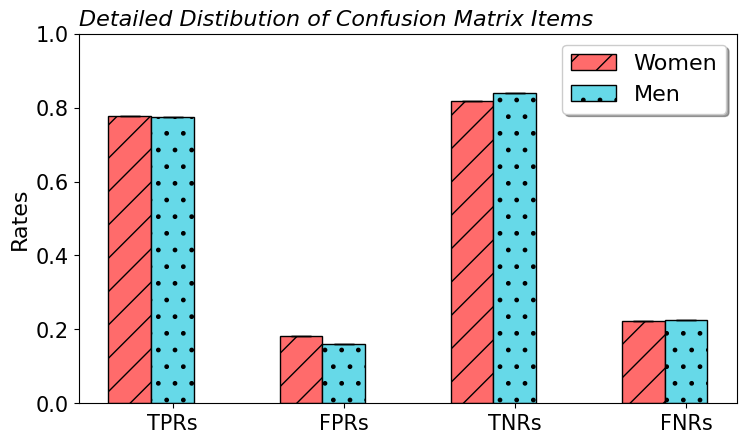

In [ ]:
# Credit - Yunyi Li

g0 = 'Women'
g1 = 'Men'

# Set the X position of Bars
r1 = np.arange(4)
barWidth = 0.25 # width of the bars
r2 = [x + barWidth for x in r1]

# Create Bars
plt.rcParams["figure.figsize"] = [8.5, 4.8]
plt.bar(r1, [TPR_g0, FPR_g0, TNR_g0, FNR_g0], width = barWidth, color = '#ff6b6b', edgecolor = 'black', yerr=0, capsize=7, hatch='/', label=g0)
plt.bar(r2, [TPR_g1, FPR_g1, TNR_g1, FNR_g1], width = barWidth, color = '#66d9e8', edgecolor = 'black', yerr=0, capsize=7, hatch='.', label=g1)

# General Layout
plt.ylim(0, 1)
plt.xticks([r + barWidth for r in range(4)], ['TPRs', 'FPRs', 'TNRs', 'FNRs'])
plt.ylabel('Rates', fontsize = 16)

# Title and Legend
plt.title('Detailed Distibution of Confusion Matrix Items', fontsize = 16, style='italic', loc='left')
plt.yticks(fontsize=15, rotation=360)
plt.xticks(fontsize=15, rotation=360)
plt.legend(loc='best', fontsize = 16, fancybox=True, shadow=True, ncol= 1)

# Show the Plot
#plt.savefig('Bar_plot_CMs.pdf',bbox_inches = 'tight') #uncomment this if you want to save the plot as pdf, so it can be used as a high resolution plot
plt.show()

In [ ]:
# Credit - Yunyi Li

# Demographic Parity Calculations
positive_rate_g0 = (sum((y_hat == 1) & (X_s_test == 0)) / sum(X_s_test == 0))
positive_rate_g1 = (sum((y_hat == 1) & (X_s_test == 1)) / sum(X_s_test == 1))
DP_violat = abs(positive_rate_g0 - positive_rate_g1)
print('The violation of demographic parity is', format(DP_violat, '.2f'))

The violation of demographic parity is 0.00


In [ ]:
# Credit - Yunyi Li

# Equalized Odds Calculations
equal_odds_g0 = sum((y_hat == 1) & (X_s_test == 0) & (y_test == 1)) / sum((X_s_test == 0) & (y_test == 1))
equal_odds_g1 = sum((y_hat == 1) & (X_s_test == 1) & (y_test == 1)) / sum((X_s_test == 1) & (y_test == 1))
Equal_Odds_violat = equal_odds_g1 - equal_odds_g0
print('The violation of equalized odds is', format(Equal_Odds_violat, '.2f'))

The violation of equalized odds is -0.00


In [ ]:
# Credit - Yunyi Li

# Predictive Parity Calculations
precision_g0 = sum((y_hat == 1) & (y_test == 1) & (X_s_test == 0)) / sum((y_hat == 1) & (X_s_test == 0))
precision_g1 = sum((y_hat == 1) & (y_test == 1) & (X_s_test == 1)) / sum((y_hat == 1) & (X_s_test == 1))
pred_parity_violat = abs(precision_g0 - precision_g1)
print('The violation of predictive parity is', format(pred_parity_violat, '.2f'))

The violation of predictive parity is 0.00


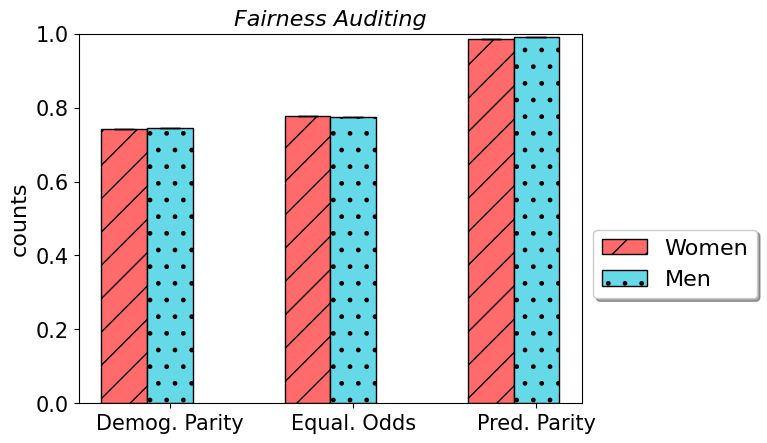

In [ ]:
# Credit - Yunyi Li

# Set the x position of bars
r1 = np.arange(3)
barWidth = 0.25 # width of the bars
r2 = [x + barWidth for x in r1]

# Create Bars
plt.rcParams["figure.figsize"] = [6.5, 4.8]
plt.bar(r1, [positive_rate_g0, equal_odds_g0, precision_g0], width=barWidth, color='#ff6b6b', edgecolor='black', yerr=0, capsize=7, hatch='/', label=g0)
plt.bar(r2, [positive_rate_g1, equal_odds_g1, precision_g1], width=barWidth, color='#66d9e8', edgecolor='black', yerr=0, capsize=7, hatch='.', label=g1)

#  General Layout
plt.ylim(0, 1)
plt.xticks([r + barWidth for r in range(3)], ['Demog. Parity', 'Equal. Odds', 'Pred. Parity'])
plt.ylabel('counts', fontsize = 16)

# Title and Legend
plt.title('Fairness Auditing', fontsize = 16, style='italic', loc='center')
plt.yticks(fontsize=15, rotation=360)
plt.xticks(fontsize=15, rotation=360)
plt.legend(loc='best', bbox_to_anchor=(1, 0.5), fontsize = 16, fancybox=True, shadow=True, ncol= 1)

# Show the Plot
#plt.savefig('Bar_plot_Measures.pdf',bbox_inches = 'tight') #uncomment this if you want to save the plot as pdf, so it can be used as a high resolution plot
plt.show()

## Analysis on Race

In [ ]:
def consolidate_race_for_stratification(df):
    race_columns = ['race1_asian', 'race1_black', 'race1_hisp', 'race1_white', 'race1_other']
    df['race_stratify'] = df[race_columns].idxmax(axis=1)
    return df

df_binarized = consolidate_race_for_stratification(df_binarized)

In [ ]:
def train_test_prepare(df, response='bar_passed', sensitive='race_stratify', train_ratio=0.67, rnd_seed=3):

    atr = df.drop(columns=[response, sensitive] + ['race1_asian', 'race1_black', 'race1_hisp', 'race1_white', 'race1_other']).columns.tolist()

    X_train, X_test, y_train, y_test = train_test_split(df[atr], df[[response, sensitive]],
                                                        stratify=df[sensitive],
                                                        test_size=1-train_ratio,
                                                        random_state=rnd_seed)

    X_s_train = y_train[sensitive]
    X_s_test = y_test[sensitive]
    y_train = y_train[response]
    y_test = y_test[response]

    return X_train, X_s_train, y_train, X_test, X_s_test, y_test

X_train, X_s_train, y_train, X_test, X_s_test, y_test = train_test_prepare(df_binarized)

In [ ]:
# Best Model as defined by Stratified K(10)-Fold GridSearchCV

# There is a clear tradeoff. ROC AUC or F1 Scoring results in a model with high FPRs across all groups but low violations.
# The opposite is true for Balanced Accuracy Scoring and Average Precision Scoring.

# ROC AUC Scoring with Class Weightage Modification
#clf = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 3, n_estimators = 100, random_state = 3)

# Balanced Accuracy Scoring with Class Weightage Modification **
clf = Pipeline([('scaler', StandardScaler()),('logistic', LogisticRegression(random_state = 3, max_iter = 1000, C = 1, class_weight = 'balanced'))])

# F1 Scoring with Class Weightage Modification
#clf = AdaBoostClassifier(algorithm= 'SAMME', n_estimators = 200, random_state = 3)

# Average Precision with Class Weightage Modification
#clf = Pipeline([('scaler', StandardScaler()),('logistic', LogisticRegression(random_state = 3, max_iter = 1000, C = 0.1, class_weight = 'balanced'))])

clf.fit(X_train, y_train)

y_hat = clf.predict(X_test)

# Classification Accuracy on Test Data
accuracy = accuracy_score(y_test, y_hat)
print(f'Accuracy: {accuracy}')

# Test AUC
test_probs = clf.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_probs)
print(f'Test AUC: {test_auc}')

# Precision for True Class; Proportion of students predicted to pass the bar who actually passed
precision = precision_score(y_test, y_hat)
print(f'Precision: {precision}')

# Recall; How well the model identifies students who actually pass the bar
recall = recall_score(y_test, y_hat)
print(f'Recall: {recall}')

Accuracy: 0.7790398918187965
Test AUC: 0.8763603202930236
Precision: 0.9863982589771491
Recall: 0.7772220634466991


In [ ]:
race_groups = X_s_test.unique()

TPR_dict, FPR_dict, TNR_dict, FNR_dict = {}, {}, {}, {}

for race in race_groups:
    race_mask = (X_s_test == race)

    TPR = np.sum((y_hat == 1) & (y_test == 1) & race_mask) / np.sum((y_test == 1) & race_mask)
    FPR = np.sum((y_hat == 1) & (y_test == 0) & race_mask) / np.sum((y_test == 0) & race_mask)
    TNR = np.sum((y_hat == 0) & (y_test == 0) & race_mask) / np.sum((y_test == 0) & race_mask)
    FNR = np.sum((y_hat == 0) & (y_test == 1) & race_mask) / np.sum((y_test == 1) & race_mask)

    TPR_dict[race], FPR_dict[race], TNR_dict[race], FNR_dict[race] = TPR, FPR, TNR, FNR

    print(f'Race: {race}, TPR: {TPR:.2f}, FPR: {FPR:.2f}, TNR: {TNR:.2f}, FNR: {FNR:.2f}')

Race: race1_white, TPR: 0.83, FPR: 0.27, TNR: 0.73, FNR: 0.17
Race: race1_black, TPR: 0.26, FPR: 0.02, TNR: 0.98, FNR: 0.74
Race: race1_other, TPR: 0.68, FPR: 0.00, TNR: 1.00, FNR: 0.32
Race: race1_asian, TPR: 0.70, FPR: 0.17, TNR: 0.83, FNR: 0.30
Race: race1_hisp, TPR: 0.51, FPR: 0.14, TNR: 0.86, FNR: 0.49


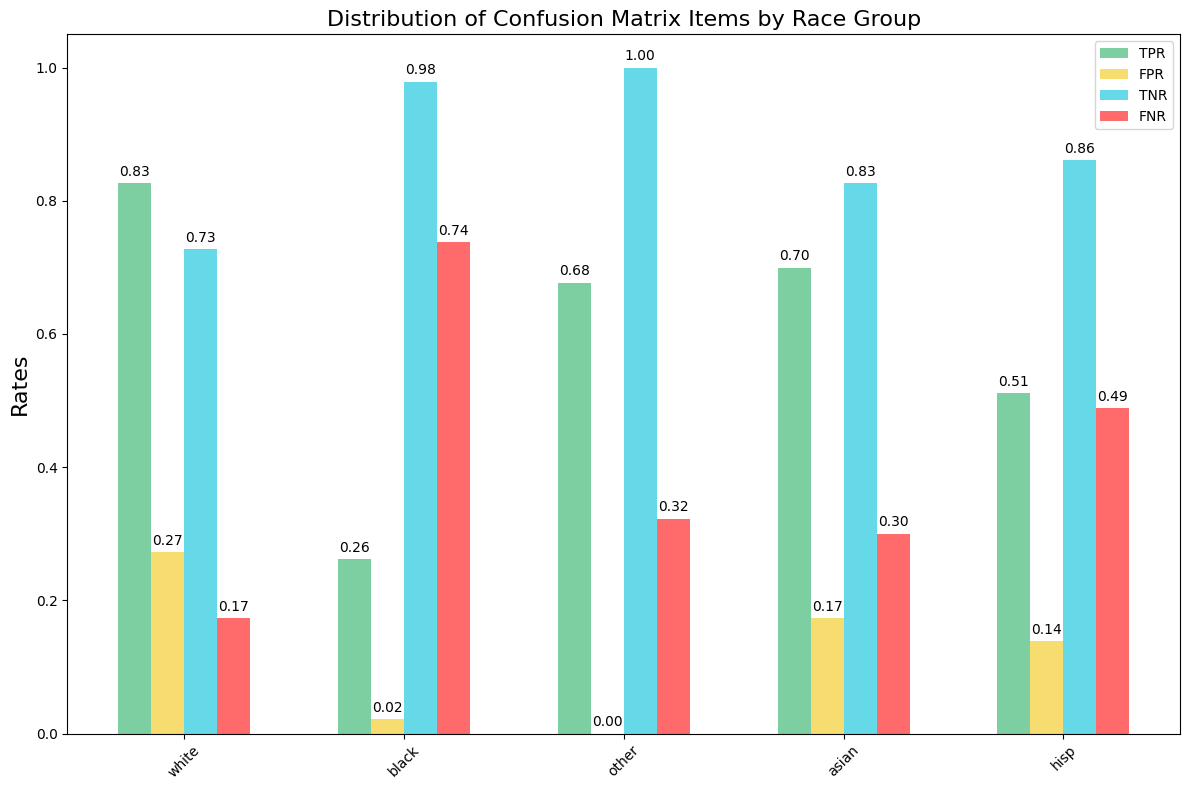

In [ ]:
race_labels = [race.replace('race1_', '') for race in race_groups]

metrics = ['TPR', 'FPR', 'TNR', 'FNR']
data = np.array([
    [TPR_dict[race] for race in race_groups],
    [FPR_dict[race] for race in race_groups],
    [TNR_dict[race] for race in race_groups],
    [FNR_dict[race] for race in race_groups],
])

num_groups = len(race_groups)
num_metrics = len(metrics)
bar_width = 0.15
index = np.arange(num_groups)
#colors = ['#ff6b6b', '#66d9e8', '#7dcea0', '#f7dc6f', '#c39bd3']
colors = ['#7dcea0', '#f7dc6f', '#66d9e8', '#ff6b6b']

plt.figure(figsize=[12, 8])

bars = []

for i, metric in enumerate(metrics):
    bar = plt.bar(index + i * bar_width, data[i], bar_width, label=metric, color=colors[i])
    bars.append(bar)

plt.xticks(index + bar_width * (num_metrics-1) / 2, race_labels, rotation=45)
plt.ylabel('Rates', fontsize=16)
plt.title('Distribution of Confusion Matrix Items by Race Group', fontsize=16)

for bar in bars:
    for rect in bar:
        height = rect.get_height()
        plt.annotate(f'{height:.2f}',
                     xy=(rect.get_x() + rect.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom')

plt.legend(loc='best', fontsize=10)
plt.tight_layout()

plt.show()

In [ ]:
race_groups = X_s_test.unique()

# Containers for metric results and pairwise violations
DP_results, EO_results, PP_results = {}, {}, {}
DP_violations, EO_violations, PP_violations = {}, {}, {}

def calc_and_print_violations(results, metric_name):
    # Calculate pairwise violations
    violations = {}
    max_violation = 0
    max_violation_groups = ""
    races = list(results.keys())

    for i, race_i in enumerate(races):
        for race_j in races[i+1:]:
            violation = abs(results[race_i] - results[race_j])
            violations[f'{race_i} vs {race_j}'] = violation

            # Identify the maximum violation
            if violation > max_violation:
                max_violation = violation
                max_violation_groups = f'{race_i} vs {race_j}'

    # Print all pairwise violations for the metric
    print(f"\n{metric_name} Pairwise Violations:")
    for pair, violation in violations.items():
        print(f"{pair}: {violation:.2f}")

    print(f"\nMaximum {metric_name} Violation is between {max_violation_groups}, with a violation of {max_violation:.2f}")

    return violations, max_violation_groups, max_violation

# Calculate metrics, pairwise violations, and print them
for race in race_groups:
    race_mask = (X_s_test == race)

    # Metrics calculation
    DP_results[race] = np.mean(y_hat[race_mask])
    EO_results[race] = np.mean(y_hat[(y_test == 1) & race_mask])
    PP_results[race] = np.sum((y_hat == 1) & (y_test == 1) & race_mask) / np.sum((y_hat == 1) & race_mask)

# Compute and print pairwise violations for each metric
DP_violations, max_DP_groups, max_DP_viol = calc_and_print_violations(DP_results, "Demographic Parity")
EO_violations, max_EO_groups, max_EO_viol = calc_and_print_violations(EO_results, "Equalized Odds")
PP_violations, max_PP_groups, max_PP_viol = calc_and_print_violations(PP_results, "Predictive Parity")


Demographic Parity Pairwise Violations:
race1_white vs race1_black: 0.60
race1_white vs race1_other: 0.17
race1_white vs race1_asian: 0.15
race1_white vs race1_hisp: 0.33
race1_black vs race1_other: 0.43
race1_black vs race1_asian: 0.45
race1_black vs race1_hisp: 0.26
race1_other vs race1_asian: 0.02
race1_other vs race1_hisp: 0.17
race1_asian vs race1_hisp: 0.19

Maximum Demographic Parity Violation is between race1_white vs race1_black, with a violation of 0.60

Equalized Odds Pairwise Violations:
race1_white vs race1_black: 0.57
race1_white vs race1_other: 0.15
race1_white vs race1_asian: 0.13
race1_white vs race1_hisp: 0.32
race1_black vs race1_other: 0.42
race1_black vs race1_asian: 0.44
race1_black vs race1_hisp: 0.25
race1_other vs race1_asian: 0.02
race1_other vs race1_hisp: 0.17
race1_asian vs race1_hisp: 0.19

Maximum Equalized Odds Violation is between race1_white vs race1_black, with a violation of 0.57

Predictive Parity Pairwise Violations:
race1_white vs race1_black: 0.

In [ ]:
# Function to simplify race labels for the next 3 visualizations
def simplify_race_labels(race_keys):
    simplified_labels = [label.split('_')[1] for label in race_keys]
    return simplified_labels

DP_labels = simplify_race_labels(DP_results.keys())
EO_labels = simplify_race_labels(EO_results.keys())
PP_labels = simplify_race_labels(PP_results.keys())

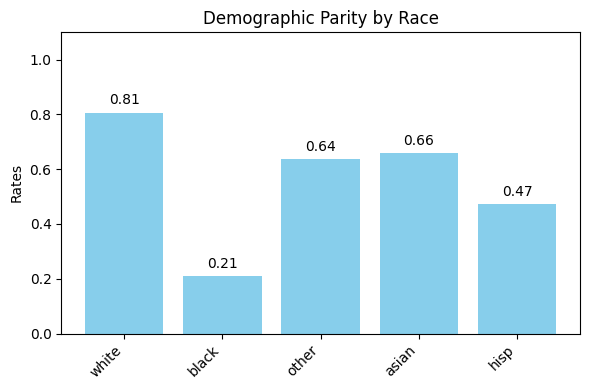

In [ ]:
plt.figure(figsize=(6, 4))
bars = plt.bar(DP_labels, DP_results.values(), color='skyblue')
plt.title('Demographic Parity by Race')
plt.ylim(0, 1.1)
plt.ylabel('Rates')
plt.xticks(rotation=45, ha = 'right')

for bar, value in zip(bars, DP_results.values()):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f"{value:.2f}",
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

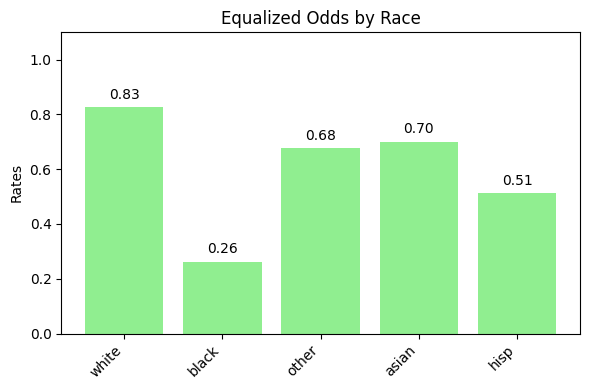

In [ ]:
plt.figure(figsize=(6, 4))
bars = plt.bar(EO_labels, EO_results.values(), color='lightgreen')
plt.title('Equalized Odds by Race')
plt.ylim(0, 1.1)
plt.ylabel('Rates')
plt.xticks(rotation=45, ha ='right')

for bar, value in zip(bars, EO_results.values()):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f"{value:.2f}",
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

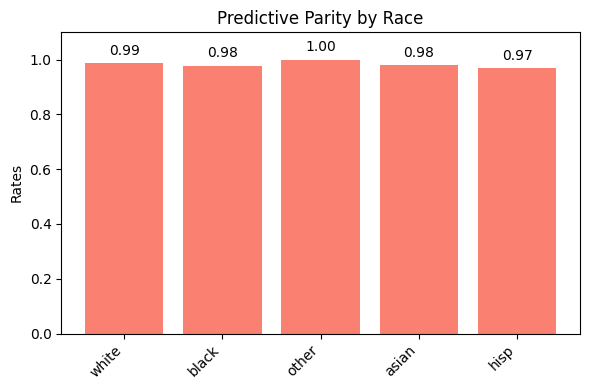

In [ ]:
plt.figure(figsize=(6, 4))
bars = plt.bar(PP_labels, PP_results.values(), color='salmon')
plt.title('Predictive Parity by Race')
plt.ylim(0, 1.1)
plt.ylabel('Rates')
plt.xticks(rotation=45, ha='right')


for bar, value in zip(bars, PP_results.values()):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f"{value:.2f}",
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

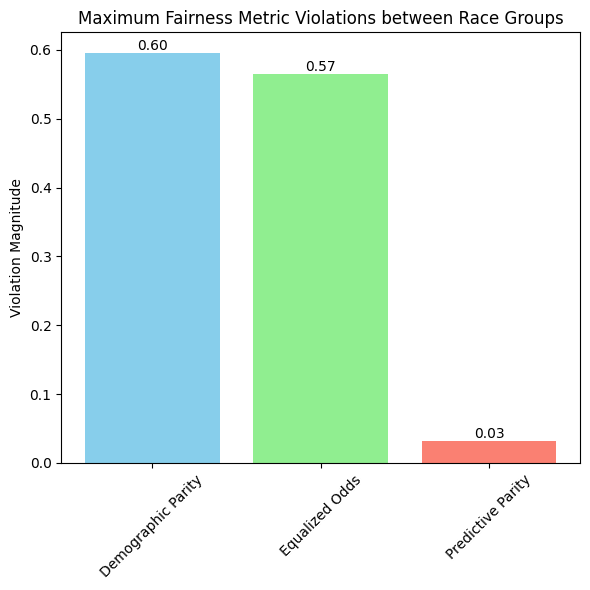

In [ ]:
plt.figure(figsize=(6, 6))
metrics = ['Demographic Parity', 'Equalized Odds', 'Predictive Parity']
violations = [max_DP_viol, max_EO_viol, max_PP_viol]
bars = plt.bar(metrics, violations, color=('skyblue', 'lightgreen', 'salmon'))
plt.title('Maximum Fairness Metric Violations between Race Groups')
plt.ylabel('Violation Magnitude')
plt.xticks(rotation=45)

for bar, value in zip(bars, violations):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{value:.2f}",
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Other Code:

In [ ]:
X = df_binarized.drop(columns=['bar_passed'])
y = df_binarized.bar_passed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=3)

perc_asian_train = (X_train['race1_asian'] == True).mean()
perc_black_train = (X_train['race1_black'] == True).mean()
perc_hisp_train = (X_train['race1_hisp'] == True).mean()
perc_white_train = (X_train['race1_white'] == True).mean()
perc_other_train = (X_train['race1_other'] == True).mean()

print('% Asian in train:', round(perc_asian_train * 100,2))
print('% Black in train:', round(perc_black_train * 100,2))
print('% Hisp in train:', round(perc_hisp_train * 100,2))
print('% White in train:', round(perc_white_train * 100,2))
print('% Other in train:', round(perc_other_train * 100,2))

perc_asian_test = (X_test['race1_asian'] == True).mean()
perc_black_test = (X_test['race1_black'] == True).mean()
perc_hisp_test = (X_test['race1_hisp'] == True).mean()
perc_white_test = (X_test['race1_white'] == True).mean()
perc_other_test = (X_test['race1_other'] == True).mean()

print('\n% Asian in test:', round(perc_asian_test * 100,2))
print('% Black in test:', round(perc_black_test * 100,2))
print('% Hisp in test:', round(perc_hisp_test * 100,2))
print('% White in test:', round(perc_white_test * 100,2))
print('% Other in test:', round(perc_other_test * 100,2))

pass_rate_asian_train = y_train[X_train['race1_asian'] == True].mean()
pass_rate_black_train = y_train[X_train['race1_black'] == True].mean()
pass_rate_hisp_train = y_train[X_train['race1_hisp'] == True].mean()
pass_rate_white_train = y_train[X_train['race1_white'] == True].mean()
pass_rate_other_train = y_train[X_train['race1_other'] == True].mean()

pass_rate_asian_test = y_test[X_test['race1_asian'] == True].mean()
pass_rate_black_test = y_test[X_test['race1_black'] == True].mean()
pass_rate_hisp_test= y_test[X_test['race1_hisp'] == True].mean()
pass_rate_white_test = y_test[X_test['race1_white'] == True].mean()
pass_rate_other_test = y_test[X_test['race1_other'] == True].mean()

print('\nTraining Data Pass Rate Absolute Differences Between Groups:')
train_pass_rates = {
    'Asian': pass_rate_asian_train,
    'Black': pass_rate_black_train,
    'Hispanic': pass_rate_hisp_train,
    'White': pass_rate_white_train,
    'Other': pass_rate_other_train
}

for race1 in train_pass_rates:
    for race2 in train_pass_rates:
        if race1 != race2:
            difference = abs(train_pass_rates[race1] - train_pass_rates[race2]) * 100
            print(f'{race1} - {race2}: {round(difference, 2)}%')

print('\nTesting Data Pass Rate Absolute Differences Between Groups:')
test_pass_rates = {
    'Asian': pass_rate_asian_test,
    'Black': pass_rate_black_test,
    'Hispanic': pass_rate_hisp_test,
    'White': pass_rate_white_test,
    'Other': pass_rate_other_test
}

for race1 in test_pass_rates:
    for race2 in test_pass_rates:
        if race1 != race2:
            difference = abs(test_pass_rates[race1] - test_pass_rates[race2]) * 100
            print(f'{race1} - {race2}: {round(difference, 2)}%')

% Asian in train: 3.98
% Black in train: 5.99
% Hisp in train: 4.54
% White in train: 83.67
% Other in train: 1.82

% Asian in test: 4.06
% Black in test: 6.0
% Hisp in test: 4.67
% White in test: 83.45
% Other in test: 1.83

Training Data Pass Rate Absolute Differences Between Groups:
Asian - Black: 14.15%
Asian - Hispanic: 4.4%
Asian - White: 4.87%
Asian - Other: 1.68%
Black - Asian: 14.15%
Black - Hispanic: 9.75%
Black - White: 19.02%
Black - Other: 12.47%
Hispanic - Asian: 4.4%
Hispanic - Black: 9.75%
Hispanic - White: 9.27%
Hispanic - Other: 2.72%
White - Asian: 4.87%
White - Black: 19.02%
White - Hispanic: 9.27%
White - Other: 6.55%
Other - Asian: 1.68%
Other - Black: 12.47%
Other - Hispanic: 2.72%
Other - White: 6.55%

Testing Data Pass Rate Absolute Differences Between Groups:
Asian - Black: 14.85%
Asian - Hispanic: 5.17%
Asian - White: 3.55%
Asian - Other: 4.11%
Black - Asian: 14.85%
Black - Hispanic: 9.67%
Black - White: 18.4%
Black - Other: 10.74%
Hispanic - Asian: 5.17%
His

In [ ]:
# One option - Create a simplified race_group column that consolidates race into two categories
# In this case, 0 = other, 1 = white. White makes up ~83% of all the records in the data.
# Then, proceed with the same analysis that was done for gender.

df_binarized['race_group'] = df_binarized['race1_white'].astype(int)
df_binarized = df_binarized.drop(columns=['race1_asian', 'race1_black', 'race1_hisp', 'race1_other'])

# Downside: Aggregating all non-White categories into a single "Other" category significantly reduces the granularity
# of our analysis. This means we won't be able to identify or address disparities that may exist between individual non-White racial groups.

# One option is to do this analysis 5 times, with each iteration focusing on a different racial group as 1 ("target group") and
# aggregating all others as 0 ("other"). This could partially mitigate the issues.

In [ ]:
import pandas as pd

# Assuming df is your dataframe
# Example: df = pd.read_csv('your_data_file.csv')

# Calculate total number of accepted individuals
total_accepted = (df['bar_passed'] == True).sum()

# Function to calculate acceptance percentages
def calculate_percentage(df, column, value):
    total = df[df[column] == value]['bar_passed'].count()
    accepted = df[(df[column] == value) & (df['bar_passed'] == 1)]['bar_passed'].count()
    percentage = (accepted / total) * 100 if total > 0 else 0
    return percentage

def passed_count(df, column, value):
    total = df[df[column] == value]['bar_passed'].count()
    return total

# Gender counts and percentages
male_count = passed_count(df,'gender',1)
male_percentage = calculate_percentage(df, 'gender', 1)
female_count = passed_count(df,'gender',0)
female_percentage = calculate_percentage(df, 'gender', 0)

# Race percentages
white_percentage = calculate_percentage(df, 'race1', 'white')
white_count = passed_count(df, 'race1','white' )
black_percentage = calculate_percentage(df, 'race1', 'black')
black_count = passed_count(df, 'race1','black' )
asian_percentage = calculate_percentage(df, 'race1', 'asian')
asian_count = passed_count(df, 'race1','asian' )
hispanic_percentage = calculate_percentage(df, 'race1', 'hisp')
hispanic_count = passed_count(df, 'race1','hisp' )

# Print results
print(f"Total Accepted: {total_accepted}")

print(f"Male Accepted Percentage: {male_percentage}%")
print(f"Total Males accepted: {male_count}")
print(f"Female Accepted Percentage: {female_percentage}%")
print(f"Total female accepted: {female_count}")

print(f"White Accepted Percentage: {white_percentage}%")
print(f"White Accepted count: {white_count}")
print(f"Black Accepted Percentage: {black_percentage}%")
print(f"Black Accepted count: {black_count}")
print(f"Asian Accepted Percentage: {asian_percentage}%")
print(f"Asian Accepted count: {asian_count}")
print(f"Hispanic Accepted Percentage: {hispanic_percentage}%")
print(f"Hispanic Accepted count: {hispanic_count}")


Total Accepted: 21237
Male Accepted Percentage: 95.22295524998012%
Total Males accepted: 12581
Female Accepted Percentage: 94.2092407897415%
Total female accepted: 9826
White Accepted Percentage: 96.62609438394192%
White Accepted count: 18732
Black Accepted Percentage: 77.8108711839166%
Black Accepted count: 1343
Asian Accepted Percentage: 92.19620958751393%
Asian Accepted count: 897
Hispanic Accepted Percentage: 87.5365141187926%
Hispanic Accepted count: 1027


In [ ]:
df_binarized = pd.get_dummies(df)
df_binarized

,decile3,decile1,lsat,ugpa,grad,fulltime,fam_inc,gender,bar_passed,tier,indxgrp,indxgrp2,race1_asian,race1_black,race1_hisp,race1_other,race1_white
0,10.0,10.0,44.0,3.5,1.0,1.0,5.0,0,True,4.0,7,9,False,False,False,False,True
1,4.0,5.0,29.0,3.5,1.0,1.0,4.0,0,True,2.0,6,6,False,False,False,False,True
2,2.0,3.0,36.0,3.5,1.0,1.0,1.0,1,True,3.0,7,8,False,False,False,False,True
3,4.0,7.0,39.0,3.5,1.0,1.0,4.0,1,True,3.0,7,8,False,False,False,False,True
4,8.0,9.0,48.0,3.5,1.0,1.0,4.0,1,True,5.0,7,9,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22402,1.0,3.0,26.5,1.8,1.0,1.0,2.0,1,False,1.0,2,2,False,True,False,False,False
22403,1.0,3.0,19.7,1.8,1.0,1.0,3.0,1,False,1.0,1,1,False,True,False,False,False
22404,8.0,7.0,36.0,1.8,1.0,2.0,3.0,1,True,3.0,5,5,False,True,False,False,False
22405,10.0,10.0,44.0,1.5,1.0,2.0,3.0,1,True,3.0,6,6,False,False,False,False,True


In [ ]:
# Calculate total number of applicants
total_applicants = len(df_binarized)

# Dictionary to hold race names and their corresponding column names in the DataFrame
race_columns = {
    'Asian': 'race1_asian',
    'Black': 'race1_black',
    'Hispanic': 'race1_hisp',
    'White': 'race1_white',
    'Other': 'race1_other'
}

# Calculate the percentage of applicants for each race
race_percentages = {}
for race, column in race_columns.items():
    race_count = df_binarized[column].sum()
    race_percentage = (race_count / total_applicants) * 100
    race_percentages[race] = race_percentage

# Display the results
print("Percentage of applicants by race:")
for race, percentage in race_percentages.items():
    print(f"{race}: {percentage:.2f}%")


Percentage of applicants by race:
Asian: 4.00%
Black: 5.99%
Hispanic: 4.58%
White: 83.60%
Other: 1.82%


## Reweighting to mitigate bias

### Down-weighting the majority

In [ ]:
# Calculate weights for each race based on inverse proportion to balance them
majority_weight = 1 / race_percentages['White']
weights = {
    race: (majority_weight if race == 'White' else 1) for race in race_columns
}

# Apply weights to the DataFrame
df_binarized['sample_weight'] = df_binarized.apply(
    lambda row: sum(weights[race] for race, col in race_columns.items() if row[col] == 1),
    axis=1
)


In [ ]:
# Check new distribution of weights
print("New distribution of sample weights by race:")
for race, col in race_columns.items():
    average_weight = df_binarized[df_binarized[col] == 1]['sample_weight'].mean()
    print(f"{race}: Average Weight = {average_weight:.2f}")

New distribution of sample weights by race:
Asian: Average Weight = 1.00
Black: Average Weight = 1.00
Hispanic: Average Weight = 1.00
White: Average Weight = 0.01
Other: Average Weight = 1.00


### Up-weighting the minority

In [ ]:
# Calculate weights for each race based on inverse proportion to balance them
total_percentage = 100  # Total percentage for normalization
weights = {
    race: total_percentage / race_percentages[race] for race in race_columns
}

# Normalize weights so they sum to the number of races to maintain overall data scale
weight_sum = sum(weights.values())
normalized_weights = {race: weight / weight_sum for race, weight in weights.items()}

# Apply normalized weights to the DataFrame
df_binarized['sample_weight'] = df_binarized.apply(
    lambda row: sum(normalized_weights[race] for race, col in race_columns.items() if row[col] == 1),
    axis=1
)

# Check new distribution of weights
print("New distribution of sample weights by race:")
for race, col in race_columns.items():
    average_weight = df_binarized[df_binarized[col] == 1]['sample_weight'].mean()
    print(f"{race}: Average Weight = {average_weight:.2f}")


New distribution of sample weights by race:
Asian: Average Weight = 0.21
Black: Average Weight = 0.14
Hispanic: Average Weight = 0.18
White: Average Weight = 0.01
Other: Average Weight = 0.46


In [ ]:
# Down-weighting the majority class
weight_majority = 1 / df_binarized['race1_white'].mean()
df_binarized['weight_down'] = df_binarized.apply(lambda x: weight_majority if x['race1_white'] == 1 else 1, axis=1)

# Up-weighting the minority classes
weights_up = {race: 1 / df_binarized[col].mean() for race, col in race_columns.items()}
df_binarized['weight_up'] = df_binarized.apply(lambda x: sum(weights_up[race] * x[col] for race, col in race_columns.items()), axis=1)


In [ ]:
# Adding sample weights directly to df_binarized for both down-weighting and up-weighting
weight_majority = 1 / df_binarized['race1_white'].mean()
df_binarized['weight_down'] = df_binarized.apply(lambda x: weight_majority if x['race1_white'] == 1 else 1, axis=1)

weights_up = {race: 1 / df_binarized[col].mean() for race, col in race_columns.items()}
df_binarized['weight_up'] = df_binarized.apply(lambda x: sum(weights_up[race] * x[col] for race, col in race_columns.items()), axis=1)


In [ ]:
# Drop NA Values
df_binarized.dropna(inplace=True)

# Down-weighting the majority class
weight_majority = 1 / df_binarized['race1_white'].mean()
df_binarized['weight_down'] = df_binarized.apply(lambda x: weight_majority if x['race1_white'] == 1 else 1, axis=1)

# Up-weighting the minority classes
weights_up = {race: 1 / df_binarized[col].mean() for race, col in race_columns.items()}
df_binarized['weight_up'] = df_binarized.apply(lambda x: sum(weights_up[race] * x[col] for race, col in race_columns.items()), axis=1)

# Ensure the weights are part of your features if needed or handled separately if not
X = df_binarized.drop(['bar_passed'], axis=1)
y = df_binarized['bar_passed']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Ensure the sample weights are not part of X_train and X_test for model training
train_weights_down = X_train['weight_down']
train_weights_up = X_train['weight_up']
X_train = X_train.drop(['weight_down', 'weight_up'], axis=1)
X_test = X_test.drop(['weight_down', 'weight_up'], axis=1)

# Model training with down-weighting
clf_down = LogisticRegression()
clf_down.fit(X_train, y_train, sample_weight=train_weights_down)

# Model training with up-weighting
clf_up = LogisticRegression()
clf_up.fit(X_train, y_train, sample_weight=train_weights_up)

# Evaluate models
y_pred_down = clf_down.predict(X_test)
y_pred_up = clf_up.predict(X_test)

print("Model Evaluation with Down-Weighting:")
print(classification_report(y_test, y_pred_down))

print("Model Evaluation with Up-Weighting:")
print(classification_report(y_test, y_pred_up))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Evaluation with Down-Weighting:
              precision    recall  f1-score   support

       False       0.51      0.08      0.14       301
        True       0.95      1.00      0.97      5854

    accuracy                           0.95      6155
   macro avg       0.73      0.54      0.56      6155
weighted avg       0.93      0.95      0.93      6155

Model Evaluation with Up-Weighting:
              precision    recall  f1-score   support

       False       0.47      0.08      0.14       301
        True       0.95      1.00      0.97      5854

    accuracy                           0.95      6155
   macro avg       0.71      0.54      0.56      6155
weighted avg       0.93      0.95      0.93      6155



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


I dont like the results bc i think we are considering too many variables. Below I run a regression to determine statistically significant variables and then rerun the log_reg

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Instantiate a logistic regression classifier
logreg = LogisticRegression()

# RFE model
rfe = RFE(estimator=logreg, n_features_to_select=5)  # Adjust n_features_to_select based on domain knowledge or based on the model complexity you are aiming for
rfe = rfe.fit(X, y)

# Summarize the selection of the attributes
print('Selected features: %s' % list(X.columns[rfe.support_]))



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Selected features: ['decile3', 'fulltime', 'tier', 'indxgrp2', 'race1_white']


In [ ]:
#Selected features: ['decile3', 'fulltime', 'tier', 'indxgrp2', 'race1_white']

In [ ]:
# Select only significant variables from RFE
significant_vars = X.columns[rfe.support_]
X_significant = X[significant_vars]

# Split the data with only significant variables
X_train_sig, X_test_sig, y_train, y_test = train_test_split(X_significant, y, test_size=0.3, random_state=42)


In [ ]:
# Ensure the sample weights are not part of X_train_sig and X_test_sig for model training
train_weights_down = X_train_sig.join(df_binarized['weight_down']).drop(significant_vars, axis=1)
train_weights_up = X_train_sig.join(df_binarized['weight_up']).drop(significant_vars, axis=1)

# Model training with down-weighting using significant variables
clf_down_sig = LogisticRegression()
clf_down_sig.fit(X_train_sig, y_train, sample_weight=train_weights_down['weight_down'])

# Model training with up-weighting using significant variables
clf_up_sig = LogisticRegression()
clf_up_sig.fit(X_train_sig, y_train, sample_weight=train_weights_up['weight_up'])

# Evaluate models using significant variables
y_pred_down_sig = clf_down_sig.predict(X_test_sig)
y_pred_up_sig = clf_up_sig.predict(X_test_sig)

print("Model Evaluation with Down-Weighting using Significant Variables:")
print(classification_report(y_test, y_pred_down_sig))

print("Model Evaluation with Up-Weighting using Significant Variables:")
print(classification_report(y_test, y_pred_up_sig))


Model Evaluation with Down-Weighting using Significant Variables:
              precision    recall  f1-score   support

       False       0.56      0.08      0.14       301
        True       0.95      1.00      0.98      5854

    accuracy                           0.95      6155
   macro avg       0.76      0.54      0.56      6155
weighted avg       0.94      0.95      0.93      6155

Model Evaluation with Up-Weighting using Significant Variables:
              precision    recall  f1-score   support

       False       0.51      0.09      0.15       301
        True       0.95      1.00      0.97      5854

    accuracy                           0.95      6155
   macro avg       0.73      0.54      0.56      6155
weighted avg       0.93      0.95      0.93      6155



In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Get precision and recall for both models
precision_down, recall_down, _, _ = precision_recall_fscore_support(y_test, y_pred_down_sig, average='binary')  # adjust 'binary' to 'macro' or 'weighted' based on your classification
precision_up, recall_up, _, _ = precision_recall_fscore_support(y_test, y_pred_up_sig, average='binary')

# Prepare data for plotting
models = ['Down-Weighting', 'Up-Weighting']
precision_scores = [precision_down, precision_up]
recall_scores = [recall_down, recall_up]


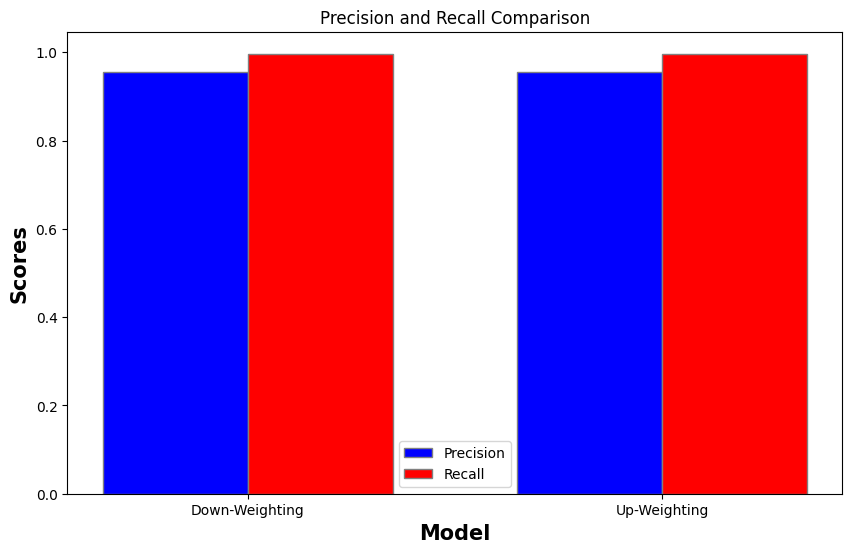

In [ ]:
barWidth = 0.35
r1 = np.arange(len(precision_scores))
r2 = [x + barWidth for x in r1]


plt.figure(figsize=(10, 6))
plt.bar(r1, precision_scores, color='b', width=barWidth, edgecolor='grey', label='Precision')
plt.bar(r2, recall_scores, color='r', width=barWidth, edgecolor='grey', label='Recall')
plt.xlabel('Model', fontweight='bold', fontsize=15)
plt.ylabel('Scores', fontweight='bold', fontsize=15)
plt.xticks([r + barWidth/2 for r in range(len(precision_scores))], models)
plt.title('Precision and Recall Comparison')
plt.legend()
plt.show()


In [ ]:
# Assuming clf_up is the full model and clf_up_sig is the significant variables model
y_pred_full_up = clf_up.predict(X_test)
y_pred_sig_up = clf_up_sig.predict(X_test_sig)

# Get precision and recall for both models
precision_full_up, recall_full_up, _, _ = precision_recall_fscore_support(y_test, y_pred_full_up, average='binary')
precision_sig_up, recall_sig_up, _, _ = precision_recall_fscore_support(y_test, y_pred_sig_up, average='binary')

models = ['Full Up-Weighted', 'Significant Up-Weighted']
precision_scores = [precision_full_up, precision_sig_up]
recall_scores = [recall_full_up, recall_sig_up]


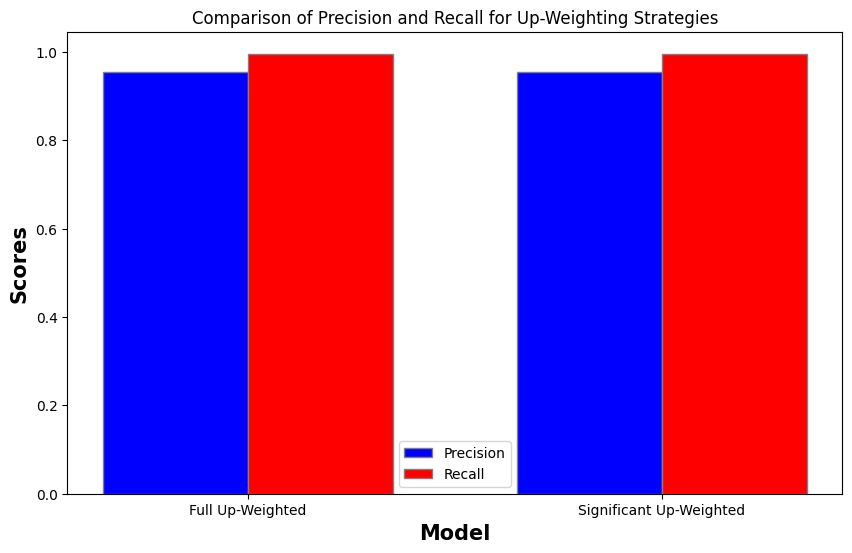

In [ ]:
barWidth = 0.35
r1 = np.arange(len(precision_scores))
r2 = [x + barWidth for x in r1]

plt.figure(figsize=(10, 6))
plt.bar(r1, precision_scores, color='blue', width=barWidth, edgecolor='grey', label='Precision')
plt.bar(r2, recall_scores, color='red', width=barWidth, edgecolor='grey', label='Recall')


plt.xlabel('Model', fontweight='bold', fontsize=15)
plt.ylabel('Scores', fontweight='bold', fontsize=15)
plt.xticks([r + barWidth/2 for r in range(len(precision_scores))], models)

plt.title('Comparison of Precision and Recall for Up-Weighting Strategies')
plt.legend()
plt.show()
